In [106]:
import db.knowhere_db as kdb
import pipeline.pipeline as pipeline
import pandas as pd
import numpy as np
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import interp

In [120]:
from scipy import integrate

def preprocess_data(df):
    # filter
    df = df[['Acceleration x','Acceleration y','Acceleration z',
             'Magnetometer x','Magnetometer y','Magnetometer z',
             'Gyrometer x','Gyrometer y','Gyrometer z',
             'classification']]
    # Get magnitudes
    df['Acceleration'] =  np.sqrt(df['Acceleration x'] ** 2 + df['Acceleration y'] ** 2 + df['Acceleration z'] ** 2)
    df['Magnetometer'] =  np.sqrt(df['Magnetometer x'] ** 2 + df['Magnetometer y'] ** 2 + df['Magnetometer z'] ** 2)

    # filter again
    df = df[['Acceleration', 'Magnetometer', 'classification']]
    
    # feature engineering
    # Rolling
    window = 7
    df['RollingMeanAcceleration7'] = df['Acceleration'].rolling(window=window,center=False).mean()
    df['RollingSDMagnetometer7'] = df['Magnetometer'].rolling(window=window,center=False).std()
    window = 10
    df['RollingMeanAcceleration10'] = df['Acceleration'].rolling(window=window,center=False).mean()
    df['RollingSDMagnetometer10'] = df['Magnetometer'].rolling(window=window,center=False).std()
    window = 15
    df['RollingMeanAcceleration15'] = df['Acceleration'].rolling(window=window,center=False).mean()
    df['RollingMeanMagnetometer15'] = df['Magnetometer'].rolling(window=window,center=False).mean()
    
    df['FirstDdtAcceleration'] = df['Acceleration'].diff(2)
    df['FirstDdtMagnetometer'] = df['Magnetometer'].diff(2)
    
    df['FirstIntAcceleration'] = df['Acceleration'].rolling(window=10,center=False).sum()
    df['FirstIntMagnetometer'] = df['Magnetometer'].rolling(window=10,center=False).sum()
    
    df = df.dropna()
    labels = df['classification']
    df = df.drop('classification', axis=1)
    
    # combine labels
    labels = labels.replace(to_replace='T_E', value='T_S')
    labels = labels.replace(to_replace='E_U', value='E')
    labels = labels.replace(to_replace='E_D', value='E')
    labels = labels.replace(to_replace='S_U', value='W')
    labels = labels.replace(to_replace='S_D', value='W')
    labels = labels.replace(to_replace='T_T', value='T_S')
    labels = labels.replace(to_replace='T_B', value='T_D')
    labels = labels.replace(to_replace='P_W', value='W')
    labels = labels.replace(to_replace='P_S', value='S')
    
    return df, labels

In [101]:
glen_train_raw = pd.read_csv("Labeled_glen_2017-03-19_to_2017-03-23_simplified.csv", index_col=0)
glen_test_raw = pd.read_csv('glen_3_24_labeled.csv', index_col=0)

In [121]:
train_data, train_labels = preprocess_data(glen_train_raw)
test_data, test_labels = preprocess_data(glen_test_raw)

c:\python27\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
pd.DataFrame(test_labels).groupby('classification').size()

classification
D      150
E        8
S       37
T_D    297
T_S     84
W      241
dtype: int64

In [122]:
# load dataset
train_X = train_data.values
train_Y = train_labels
encoder = LabelEncoder()
encoder.fit(train_Y)
train_encoded_Y = encoder.transform(train_Y)

In [123]:
test_X = test_data.values
test_Y = test_labels
encoder = LabelEncoder()
encoder.fit(test_Y)
test_encoded_Y = encoder.transform(test_Y)

In [79]:
# build a classifier
RF_Class = RandomForestClassifier(n_estimators=200)
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, 3, 2, 10, 13, 27, None],
              "max_features": sp_randint(1,9),
              "min_samples_split": sp_randint(2, 100),
              "min_samples_leaf": sp_randint(1, 100),
              "bootstrap": [True],
              "criterion": ["gini"]}

# run randomized search
n_iter_search = 25
random_search = RandomizedSearchCV(RF_Class, param_distributions=param_dist, n_iter=n_iter_search)

start = time()
random_search.fit(train_X, train_encoded_Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 757.54 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.731 (std: 0.036)
Parameters: {'bootstrap': True, 'min_samples_leaf': 91, 'min_samples_split': 73, 'criterion': 'gini', 'max_features': 3, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.730 (std: 0.038)
Parameters: {'bootstrap': True, 'min_samples_leaf': 53, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': 2, 'max_depth': 13}

Model with rank: 3
Mean validation score: 0.729 (std: 0.039)
Parameters: {'bootstrap': True, 'min_samples_leaf': 78, 'min_samples_split': 63, 'criterion': 'gini', 'max_features': 4, 'max_depth': 10}



In [80]:
RF_Class = RandomForestClassifier(bootstrap=True,min_samples_leaf=16,n_estimators=1500,\
                                  min_samples_split=80, criterion='gini', max_features=3, max_depth=None)

In [124]:
RF_Class.fit(train_X, train_encoded_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=16,
            min_samples_split=80, min_weight_fraction_leaf=0.0,
            n_estimators=1500, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 10 (0.143403)
2. feature 6 (0.143056)
3. feature 5 (0.137127)
4. feature 4 (0.118243)
5. feature 3 (0.109991)


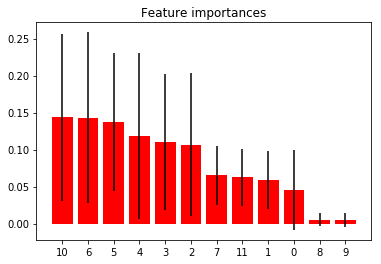

In [117]:
importances = RF_Class.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_Class.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])
plt.show()

In [116]:
#x_train,x_test, y_train, y_test = train_test_split(X, encoded_Y, test_size=0.33, random_state=41010392)
predictions = RF_Class.predict(test_X)
print accuracy_score(test_encoded_Y, predictions)
print confusion_matrix(test_encoded_Y, predictions)

0.61811505508
[[ 88   0   0  11   0  51]
 [  0   0   0   0   0   8]
 [  5   0   0   4   0  28]
 [  3   0  11 269   0  14]
 [  0   0   0   4   0  80]
 [ 50   0   0  43   0 148]]
